In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
X_df = pd.read_csv("drive/MyDrive/GEOSpatial/features.csv")
y_df = pd.read_csv("drive/MyDrive/GEOSpatial/targets.csv")

In [ ]:
X_df

,ID,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,DIVERTED,CANCELLED,CANCELLATION_REASON
0,5133505,2021,2,14,6,AA,1077,N454AA,BWI,DFW,...,-9.0,10,832,224.0,168.0,1217,1115,0,0,NaN
1,5051259,2021,12,4,5,WN,2510,N656SW,ONT,SMF,...,2.0,7,939,80.0,65.0,390,1050,0,0,NaN
2,5340710,2021,7,7,2,MQ,3204,N696MQ,DFW,LCH,...,-6.0,12,2216,73.0,52.0,295,2323,0,0,NaN
3,5445255,2021,1,4,7,B6,777,N585JB,BOS,LAS,...,10.0,17,2032,363.0,329.0,2381,2308,0,0,NaN
4,2473736,2021,6,16,2,WN,4924,N462WN,LAX,OAK,...,39.0,8,1822,75.0,54.0,337,1850,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5314003,3089553,2021,12,22,2,DL,611,N199DN,LAX,HNL,...,8.0,20,858,360.0,312.0,2556,1230,0,0,NaN
5314004,4917798,2021,9,1,2,OO,4589,N803SK,LGB,SLC,...,-8.0,14,1311,108.0,83.0,588,1553,0,0,NaN
5314005,3723223,2021,6,16,2,EV,2668,N680AE,VPS,DFW,...,330.0,7,1949,128.0,93.0,641,1620,0,0,NaN
5314006,690512,2021,4,8,3,DL,1731,N595NW,LAX,ATL,...,15.0,15,145,249.0,213.0,1947,824,0,0,NaN


In [ ]:
df = pd.concat([X_df, y_df], axis=1)

In [ ]:
class_counts = df['DESTINATION_AIRPORT'].value_counts()

In [ ]:
singleton_classes = class_counts[class_counts < 2].index

In [ ]:
singleton_classes

Index(['10666'], dtype='object')

In [ ]:
df = df[~df['DESTINATION_AIRPORT'].isin(singleton_classes)]

In [ ]:
df = df.loc[:, ~df.columns.duplicated()]

# **Train/Test split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('ARRIVAL_DELAY', axis=1),
    df['ARRIVAL_DELAY'],
    test_size=0.02,
    random_state=42
)

In [ ]:
label_X_train = X_train.copy()
label_X_test = X_test.copy()

# **Encoding varchar coolumns**

In [ ]:
label_encoder = LabelEncoder()
label_X_train['TAIL_NUMBER'] = label_encoder.fit_transform(X_train['TAIL_NUMBER'])
label_X_test['TAIL_NUMBER'] = label_encoder.transform(X_test['TAIL_NUMBER'])

In [ ]:
label_encoder2 = LabelEncoder()
label_X_train['AIRLINE'] = label_encoder2.fit_transform(X_train['AIRLINE'])
label_X_test['AIRLINE'] = label_encoder2.transform(X_test['AIRLINE'])

In [ ]:
combined_data = pd.concat([label_X_train, label_X_test])

label_encoder3 = LabelEncoder()
combined_data['ORIGIN_AIRPORT'] = label_encoder3.fit_transform(combined_data['ORIGIN_AIRPORT'])
combined_data['DESTINATION_AIRPORT'] = label_encoder3.fit_transform(combined_data['DESTINATION_AIRPORT'])

label_X_train = combined_data[:len(label_X_train)]
label_X_test = combined_data[len(label_X_train):]

In [ ]:
X_train = label_X_train
X_test = label_X_test

In [ ]:
best_columns = ["ID", "SCHEDULED_DEPARTURE", "DEPARTURE_TIME", "DEPARTURE_DELAY",
                "TAXI_OUT", "WHEELS_OFF", "SCHEDULED_ARRIVAL", "ORIGIN_AIRPORT",
                "DESTINATION_AIRPORT"]

In [ ]:
X_train = X_train[best_columns]
X_test = X_test[best_columns]

# **Inputing missing values**

In [ ]:
cols_with_missing_train = X_train.columns[X_train.isnull().any()].tolist()
cols_with_missing_test = X_test.columns[X_test.isnull().any()].tolist()
print(cols_with_missing_train, cols_with_missing_test)

cols_with_missing = list(set(cols_with_missing_train + cols_with_missing_test))

numeric_cols = X_train.select_dtypes(include=['number']).columns
categorical_cols = X_train.select_dtypes(exclude=['number']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

imputed_X_train = pd.DataFrame(preprocessor.fit_transform(X_train))
imputed_X_test = pd.DataFrame(preprocessor.transform(X_test))

numeric_cols = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=['number']).columns.tolist()

print(f"Number of columns in imputed_X_train: {len(imputed_X_train.columns)}")
print(f"Number of columns in imputed_X_test: {len(imputed_X_test.columns)}")

imputed_X_train.columns = numeric_cols + categorical_cols
imputed_X_test.columns = numeric_cols + categorical_cols

[] []
Number of columns in imputed_X_train: 9
Number of columns in imputed_X_test: 9


In [ ]:
X_train = imputed_X_train.astype(int)
X_test = imputed_X_test.astype(int)

In [ ]:
X = X_train.drop(columns=['ID'])
X_t = X_test.drop(columns=['ID'])

# **XGBOOST**

In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=800, learning_rate=0.05, n_jobs=4)

xgb_model.fit(X, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=4,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_test_pred = xgb_model.predict(X_t)

submission_df = pd.DataFrame(data={'ID': X_test.ID.values,
                                   'ARRIVAL_DELAY': y_test_pred.squeeze()})

submission_df.to_csv("submission_xgboost.csv", index=False)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_test = y_test
y_pred = y_test_pred

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)


print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

MAE: 7.0806175024133635
MSE: 100.20152010062418
RMSE: 10.010070933845782
R^2: 0.9340263882023682


# **DecisionTree**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(max_depth=5, min_samples_split=2, min_samples_leaf=1, max_features=None, random_state=42)

tree_model.fit(X, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [ ]:
y_test_pred = tree_model.predict(X_t)

submission_df = pd.DataFrame(data={'ID': X_test.ID.values,
                                   'ARRIVAL_DELAY': y_test_pred.squeeze()})

submission_df.to_csv("submission_decision_tree.csv", index=False)

In [ ]:
y_test = y_test
y_pred = y_test_pred

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)


print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

MAE: 8.64500023593921
MSE: 142.415420852133
RMSE: 11.93379322982148
R^2: 0.9062323637419902


# **RANDOM FOREST**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(n_estimators = 12, verbose=True)
forest_model.fit(X, y_train)

RandomForestRegressor(n_estimators=12, verbose=True)

In [ ]:
y_test_pred = forest_model.predict(X_t)

submission_df = pd.DataFrame(data={'ID': X_test.ID.values,
                                   'ARRIVAL_DELAY': y_test_pred.squeeze()})

submission_df.to_csv("submission_forest.csv", index=False)

OSError: Cannot save file into a non-existent directory: '/kaggle/working'

In [ ]:
y_test = y_test
y_pred = y_test_pred

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)


print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

MAE: 7.452251232384279
MSE: 109.99670789822024
RMSE: 10.48793153573288
R^2: 0.9275771455502153


# **Wyniki**

In [ ]:
data = {
    'Model': ['XGBOOST', 'DecisionTree', 'RANDOM FOREST'],
    'MAE': [7.08, 8.65, 7.45],
    'MSE': [100, 142, 110],
    'RMSE': [10, 11.93, 10.49],
    'R^2': [0.93, 0.90, 0.93]
}

df = pd.DataFrame(data)


In [ ]:
print(df)

           Model   MAE  MSE   RMSE   R^2
0        XGBOOST  7.08  100  10.00  0.93
1   DecisionTree  8.65  142  11.93  0.90
2  RANDOM FOREST  7.45  110  10.49  0.93


# **+Reprezentacja lotnisk**

In [ ]:
import numpy as np
import ast

In [ ]:
X_df = pd.read_csv("drive/MyDrive/GEOSpatial/features.csv")
y_df = pd.read_csv("drive/MyDrive/GEOSpatial/targets.csv")

In [ ]:
X_rep = pd.read_csv("drive/MyDrive/GEOSpatial/airport_representation-2.csv") #1 option
#X_rep = pd.read_csv("drive/MyDrive/GEOSpatial/airport_representation-2.csv") #2 option

In [ ]:
X_rep['Representation'] = X_rep['Representation'].apply(lambda x: np.array(ast.literal_eval(x), dtype=np.float))

<ipython-input-8-50c80bcd073c>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_rep['Representation'] = X_rep['Representation'].apply(lambda x: np.array(ast.literal_eval(x), dtype=np.float))


In [ ]:
X_rep

,Airport,Representation
0,DFW,"[1.2297251224517822, 0.16540391743183136, 0.63..."
1,BWI,"[1.41794753074646, 0.13733047246932983, 0.2455..."
2,SMF,"[0.017414767295122147, 0.13441374897956848, 0...."
3,ONT,"[0.0, 0.10550469905138016, 0.49953240156173706..."
4,LCH,"[0.01567821018397808, 0.004727749153971672, 0...."
...,...,...
317,ILG,"[0.42490682005882263, 0.0, 0.0, 0.0, 0.1501445..."
318,AKN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.605..."
319,GST,"[0.0, 0.0, 0.007566665764898062, 0.0, 0.0, 0.0..."
320,CNY,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.156..."


In [ ]:
combined_df = pd.merge(X_df, X_rep, left_on='ORIGIN_AIRPORT', right_on='Airport', how='left')

In [ ]:
X_df = pd.merge(combined_df, X_rep, left_on='DESTINATION_AIRPORT', right_on='Airport', how='left')

In [ ]:
X_df

,ID,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,DIVERTED,CANCELLED,CANCELLATION_REASON,Airport_x,Representation_x,Airport_y,Representation_y,Representation_x_mean,Representation_y_mean,Mean
0,5133505,2021,2,14,6,AA,1077,N454AA,BWI,DFW,...,0,0,NaN,BWI,"[0.5142310261726379, 0.4705844819545746, 0.0, ...",DFW,"[0.28220289945602417, 0.035693101584911346, 0....",0.405436,0.260335,0.332885
1,5051259,2021,12,4,5,WN,2510,N656SW,ONT,SMF,...,0,0,NaN,ONT,"[0.0, 0.1453670710325241, 0.0, 0.3538846969604...",SMF,"[0.0, 0.5886985063552856, 0.0, 0.1839753538370...",0.225305,0.277105,0.251205
2,5340710,2021,7,7,2,MQ,3204,N696MQ,DFW,LCH,...,0,0,NaN,DFW,"[0.28220289945602417, 0.035693101584911346, 0....",LCH,"[0.0, 0.40515002608299255, 0.0, 0.0, 0.0, 0.63...",0.260335,0.130475,0.195405
3,5445255,2021,1,4,7,B6,777,N585JB,BOS,LAS,...,0,0,NaN,BOS,"[0.6367199420928955, 0.5685775279998779, 0.028...",LAS,"[0.0, 0.0, 0.34421294927597046, 0.0, 0.3776198...",0.426091,0.157626,0.291859
4,2473736,2021,6,16,2,WN,4924,N462WN,LAX,OAK,...,0,0,NaN,LAX,"[0.48011887073516846, 0.28913405537605286, 0.0...",OAK,"[0.10630263388156891, 0.6059154272079468, 0.0,...",0.356632,0.292627,0.324630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5314003,3089553,2021,12,22,2,DL,611,N199DN,LAX,HNL,...,0,0,NaN,LAX,"[0.48011887073516846, 0.28913405537605286, 0.0...",HNL,"[0.16141733527183533, 1.1670565605163574, 0.0,...",0.356632,0.275669,0.316151
5314004,4917798,2021,9,1,2,OO,4589,N803SK,LGB,SLC,...,0,0,NaN,LGB,"[0.0, 0.35703331232070923, 0.0801352858543396,...",SLC,"[0.0, 0.0, 1.3113659620285034, 0.0, 1.40304243...",0.305286,0.407714,0.356500
5314005,3723223,2021,6,16,2,EV,2668,N680AE,VPS,DFW,...,0,0,NaN,VPS,"[0.0, 0.1796356588602066, 0.0, 0.0414777770638...",DFW,"[0.28220289945602417, 0.035693101584911346, 0....",0.127686,0.260335,0.194011
5314006,690512,2021,4,8,3,DL,1731,N595NW,LAX,ATL,...,0,0,NaN,LAX,"[0.48011887073516846, 0.28913405537605286, 0.0...",ATL,"[0.3136797249317169, 0.16515356302261353, 0.0,...",0.356632,0.252710,0.304671


Without mean #1 option

In [ ]:
X_df['Representation_x'] = X_df['Representation_x'].apply(lambda x: x if isinstance(x, (list, np.ndarray)) else np.array([]).tolist())

In [ ]:
new_columns = pd.DataFrame(X_df['Representation_x'].values.tolist(), columns=[f'kolumna_x_{i+1}' for i in range(len(X_df['Representation_x'].iloc[0]))])

In [ ]:
X_df = pd.concat([X_df, new_columns], axis=1)

In [ ]:
X_df['Representation_y'] = X_df['Representation_y'].apply(lambda x: x if isinstance(x, (list, np.ndarray)) else np.array([]).tolist())

In [ ]:
new_columns = pd.DataFrame(X_df['Representation_y'].values.tolist(), columns=[f'kolumna_y_{i+1}' for i in range(len(X_df['Representation_y'].iloc[0]))])

In [ ]:
X_df = pd.concat([X_df, new_columns], axis=1)

With mean #2 option

In [ ]:
X_df['Representation_x_mean'] = X_df['Representation_x'].apply(lambda x: sum(x) / len(x) if isinstance(x, (list, np.ndarray)) else 0)
X_df['Representation_y_mean'] = X_df['Representation_y'].apply(lambda x: sum(x) / len(x) if isinstance(x, (list, np.ndarray)) else 0)

In [ ]:
X_df['Mean'] = (X_df['Representation_x_mean'] + X_df['Representation_y_mean']) / 2

Drop duplicates and columns

In [ ]:
X_df.drop(columns=['Airport_x', 'Airport_y'], inplace=True)

In [ ]:
X_df.drop(columns=['Representation_x', 'Representation_y'], inplace=True)

In [ ]:
df = pd.concat([X_df, y_df], axis=1)

In [ ]:
class_counts = df['DESTINATION_AIRPORT'].value_counts()

In [ ]:
singleton_classes = class_counts[class_counts < 2].index

In [ ]:
singleton_classes

Index(['10666'], dtype='object')

In [ ]:
df = df[~df['DESTINATION_AIRPORT'].isin(singleton_classes)]

In [ ]:
df = df.loc[:, ~df.columns.duplicated()]

In [ ]:
df.dropna(subset=['ID'], inplace=True)

In [ ]:
df

,ID,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,DIVERTED,CANCELLED,CANCELLATION_REASON,Representation_x_mean,Representation_y_mean,Mean,ARRIVAL_DELAY
0,5133505,2021,2,14,6,AA,1077,N454AA,BWI,DFW,...,168.0,1217,1115,0,0,NaN,0.405436,0.260335,0.332885,-35.0
1,5051259,2021,12,4,5,WN,2510,N656SW,ONT,SMF,...,65.0,390,1050,0,0,NaN,0.225305,0.277105,0.251205,-2.0
2,5340710,2021,7,7,2,MQ,3204,N696MQ,DFW,LCH,...,52.0,295,2323,0,0,NaN,0.260335,0.130475,0.195405,-10.0
3,5445255,2021,1,4,7,B6,777,N585JB,BOS,LAS,...,329.0,2381,2308,0,0,NaN,0.426091,0.157626,0.291859,-1.0
4,2473736,2021,6,16,2,WN,4924,N462WN,LAX,OAK,...,54.0,337,1850,0,0,NaN,0.356632,0.292627,0.324630,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5314003,3089553,2021,12,22,2,DL,611,N199DN,LAX,HNL,...,312.0,2556,1230,0,0,NaN,0.356632,0.275669,0.316151,-16.0
5314004,4917798,2021,9,1,2,OO,4589,N803SK,LGB,SLC,...,83.0,588,1553,0,0,NaN,0.305286,0.407714,0.356500,-11.0
5314005,3723223,2021,6,16,2,EV,2668,N680AE,VPS,DFW,...,93.0,641,1620,0,0,NaN,0.127686,0.260335,0.194011,310.0
5314006,690512,2021,4,8,3,DL,1731,N595NW,LAX,ATL,...,213.0,1947,824,0,0,NaN,0.356632,0.252710,0.304671,-2.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('ARRIVAL_DELAY', axis=1),
    df['ARRIVAL_DELAY'],
    test_size=0.02,
    random_state=45
)

In [ ]:
label_X_train = X_train.copy()
label_X_test = X_test.copy()

In [ ]:
label_encoder = LabelEncoder()
label_X_train['TAIL_NUMBER'] = label_encoder.fit_transform(X_train['TAIL_NUMBER'])
label_X_test['TAIL_NUMBER'] = label_encoder.transform(X_test['TAIL_NUMBER'])

In [ ]:
label_encoder2 = LabelEncoder()
label_X_train['AIRLINE'] = label_encoder2.fit_transform(X_train['AIRLINE'])
label_X_test['AIRLINE'] = label_encoder2.transform(X_test['AIRLINE'])

In [ ]:
combined_data = pd.concat([label_X_train, label_X_test])

label_encoder3 = LabelEncoder()
combined_data['ORIGIN_AIRPORT'] = label_encoder3.fit_transform(combined_data['ORIGIN_AIRPORT'])
combined_data['DESTINATION_AIRPORT'] = label_encoder3.fit_transform(combined_data['DESTINATION_AIRPORT'])

label_X_train = combined_data[:len(label_X_train)]
label_X_test = combined_data[len(label_X_train):]

In [ ]:
X_train = label_X_train
X_test = label_X_test

In [ ]:
best_columns = ["ID", "SCHEDULED_DEPARTURE", "DEPARTURE_TIME", "DEPARTURE_DELAY",
                "TAXI_OUT", "WHEELS_OFF", "SCHEDULED_ARRIVAL", "ORIGIN_AIRPORT",
                "DESTINATION_AIRPORT",'Representation_x_mean','Representation_y_mean', 'Mean'] #Without mean #1 option
                #'kolumna_y_1','kolumna_y_2','kolumna_y_3','kolumna_y_4','kolumna_y_5','kolumna_y_6','kolumna_y_7','kolumna_y_8','kolumna_y_9','kolumna_y_10'
               #, 'kolumna_x_1','kolumna_x_2','kolumna_x_3','kolumna_x_4','kolumna_yx_5','kolumna_x_6','kolumna_x_7','kolumna_x_8','kolumna_x_9','kolumna_x_10'] #With mean #2 option

In [ ]:
X_train = X_train[best_columns]
X_test = X_test[best_columns]

In [ ]:
cols_with_missing_train = X_train.columns[X_train.isnull().any()].tolist()
cols_with_missing_test = X_test.columns[X_test.isnull().any()].tolist()
print(cols_with_missing_train, cols_with_missing_test)

cols_with_missing = list(set(cols_with_missing_train + cols_with_missing_test))

numeric_cols = X_train.select_dtypes(include=['number']).columns
categorical_cols = X_train.select_dtypes(exclude=['number']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

imputed_X_train = pd.DataFrame(preprocessor.fit_transform(X_train))
imputed_X_test = pd.DataFrame(preprocessor.transform(X_test))

numeric_cols = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=['number']).columns.tolist()

print(f"Number of columns in imputed_X_train: {len(imputed_X_train.columns)}")
print(f"Number of columns in imputed_X_test: {len(imputed_X_test.columns)}")

imputed_X_train.columns = numeric_cols + categorical_cols
imputed_X_test.columns = numeric_cols + categorical_cols

[] []
Number of columns in imputed_X_train: 12
Number of columns in imputed_X_test: 12


In [ ]:
X_train = imputed_X_train.astype(int)
X_test = imputed_X_test.astype(int)

In [ ]:
X = X_train.drop(columns=['ID'])
X_t = X_test.drop(columns=['ID'])

In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=800, learning_rate=0.05, n_jobs=4)

xgb_model.fit(X, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=4,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_test_pred = xgb_model.predict(X_t)

submission_df = pd.DataFrame(data={'ID': X_test.ID.values,
                                   'ARRIVAL_DELAY': y_test_pred.squeeze()})

submission_df.to_csv("submission_xgboost.csv", index=False)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_test = y_test
y_pred = y_test_pred

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)


print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

MAE: 7.091264574839416
MSE: 111.14926439855155
RMSE: 10.542735147889827
R^2: 0.9285475901548061


In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(max_depth=7, min_samples_split=2, min_samples_leaf=1, max_features=None, random_state=42)

tree_model.fit(X, y_train)

DecisionTreeRegressor(max_depth=7, random_state=42)

In [ ]:
y_test_pred = tree_model.predict(X_t)

submission_df = pd.DataFrame(data={'ID': X_test.ID.values,
                                   'ARRIVAL_DELAY': y_test_pred.squeeze()})

submission_df.to_csv("submission_decision_tree.csv", index=False)

In [ ]:
y_test = y_test
y_pred = y_test_pred

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)


print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

MAE: 8.05366186720541
MSE: 122.56926810731753
RMSE: 11.071100582476772
R^2: 0.9212062299591464


In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(n_estimators = 12, verbose=True)
forest_model.fit(X, y_train)

In [ ]:
y_test_pred = forest_model.predict(X_t)

submission_df = pd.DataFrame(data={'ID': X_test.ID.values,
                                   'ARRIVAL_DELAY': y_test_pred.squeeze()})

submission_df.to_csv("submission_forest.csv", index=False)

In [ ]:
y_test = y_test
y_pred = y_test_pred

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)


print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

# **Wyniki (+rep)**

In [ ]:
data = {
    'Model': ['XGBOOST', 'DecisionTree', 'RANDOM FOREST'],
    'MAE': [7.09, 8.65, 7.45],
    'MSE': [110, 143, 109],
    'RMSE': [10.49, 11.96, 10.45],
    'R^2': [0.93, 0.91, 0.93]
}

df = pd.DataFrame(data)

In [ ]:
print(df)

           Model   MAE  MSE   RMSE   R^2
0        XGBOOST  7.09  110  10.49  0.93
1   DecisionTree  8.65  143  11.96  0.91
2  RANDOM FOREST  7.45  109  10.45  0.93


# **Wyniki (+loc)**


In [ ]:
data = {
    'Model': ['XGBOOST', 'DecisionTree', 'RANDOM FOREST'],
    'MAE': [7.09, 8.05, 7.43],
    'MSE': [111, 122, 108],
    'RMSE': [10.54, 11.07, 10.41],
    'R^2': [0.93, 0.92, 0.92]
}

df = pd.DataFrame(data)

In [ ]:
print(df)

           Model   MAE  MSE   RMSE   R^2
0        XGBOOST  7.09  111  10.54  0.93
1   DecisionTree  8.05  122  11.07  0.92
2  RANDOM FOREST  7.43  108  10.41  0.92


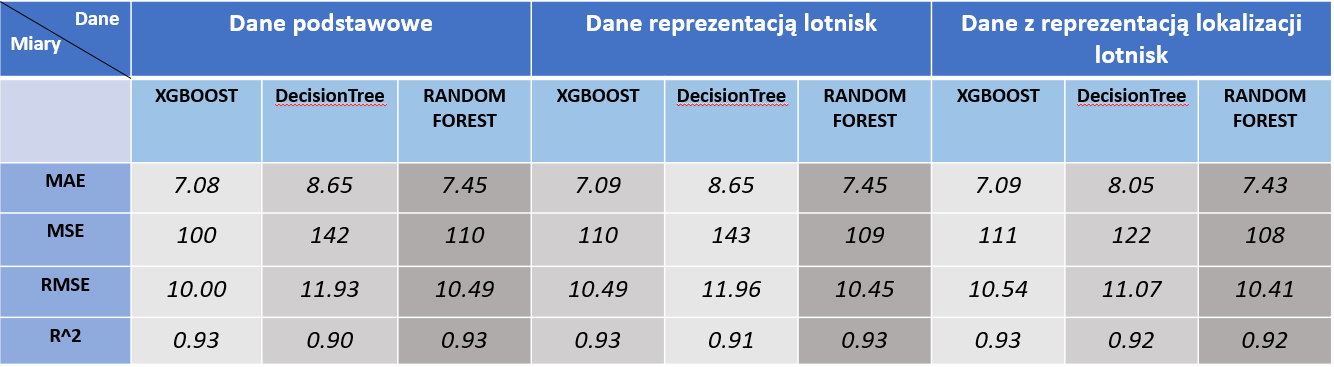![image.png](
  **pogrubiony tekst**
)

# **Clustering**

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
df = pd.DataFrame(X_rep)

pca = PCA(n_components=3)
pca_result = pca.fit_transform(np.array(df['Representation'].tolist()))


tsne = TSNE(n_components=3, perplexity=30, n_iter=1000)
tsne_result = tsne.fit_transform(np.array(df['Representation'].tolist()))


kmeans = KMeans(n_clusters=3)
kmeans.fit(np.array(df['Representation'].tolist()))
clusters = kmeans.labels_


df['PCA1'] = pca_result[:,0]
df['PCA2'] = pca_result[:,1]
df['PCA3'] = pca_result[:,2]
df['tSNE1'] = tsne_result[:,0]
df['tSNE2'] = tsne_result[:,1]
df['tSNE3'] = tsne_result[:,2]
df['Cluster'] = clusters

print(df)

    Airport                                     Representation      PCA1  \
0       DFW  [1.2297251224517822, 0.16540391743183136, 0.63...  1.978706   
1       BWI  [1.41794753074646, 0.13733047246932983, 0.2455...  1.288891   
2       SMF  [0.017414767295122147, 0.13441374897956848, 0....  0.383852   
3       ONT  [0.0, 0.10550469905138016, 0.49953240156173706...  0.535811   
4       LCH  [0.01567821018397808, 0.004727749153971672, 0.... -0.530518   
..      ...                                                ...       ...   
317     ILG  [0.42490682005882263, 0.0, 0.0, 0.0, 0.1501445... -0.219097   
318     AKN  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.605... -0.531146   
319     GST  [0.0, 0.0, 0.007566665764898062, 0.0, 0.0, 0.0... -0.521092   
320     CNY  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.156... -0.557745   
321     ITH  [0.48981326818466187, 0.08282214403152466, 0.0... -0.224783   

         PCA2      tSNE1     tSNE2  Cluster      PCA3     tSNE3  
0    0.201179  10.448

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


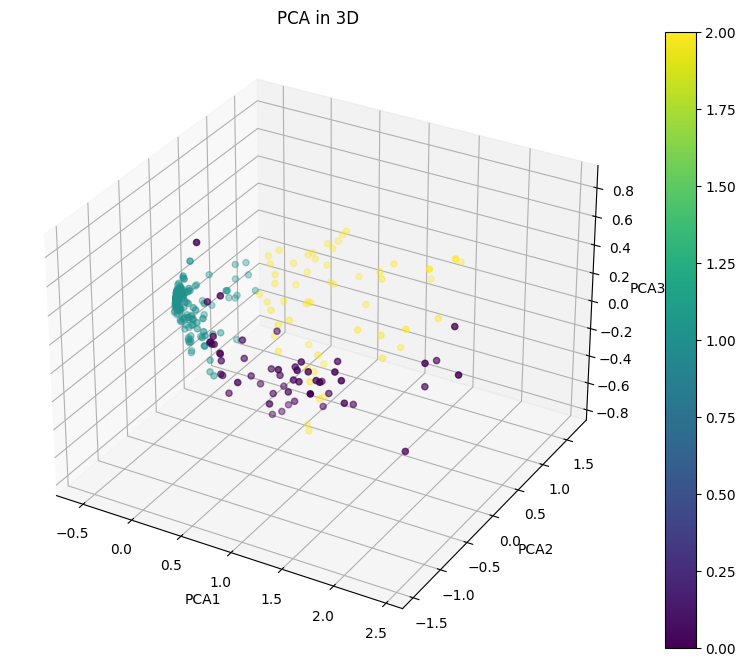

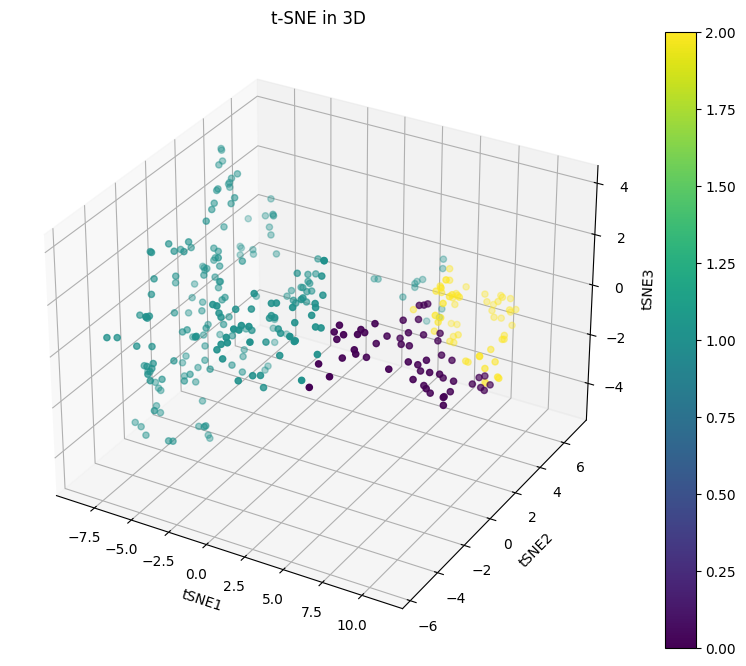

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['PCA1'], df['PCA2'], df['PCA3'], c=df['Cluster'], cmap='viridis')
ax.set_title('PCA in 3D')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.colorbar(scatter)
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['tSNE1'], df['tSNE2'], df['tSNE3'], c=df['Cluster'], cmap='viridis')
ax.set_title('t-SNE in 3D')
ax.set_xlabel('tSNE1')
ax.set_ylabel('tSNE2')
ax.set_zlabel('tSNE3')
plt.colorbar(scatter)
plt.show()